# Review misclassified examples

Load packages

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.metrics import confusion_matrix

Load Model

In [3]:
model = tf.keras.models.load_model('/tmp/ml-pipeline/model/saved_model')

2023-05-24 12:35:40.334082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-24 12:35:40.334117: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-24 12:35:40.334141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (notebook-0): /proc/driver/nvidia/version does not exist
2023-05-24 12:35:40.334342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load data

In [4]:
import boto3
from boto3 import session
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [21]:
X_val = np.load('/tmp/ml-pipeline/data/X_val.npy')
y_val = np.load('/tmp/ml-pipeline/data/y_val.npy')
X_train = np.load('/tmp/ml-pipeline/data/X_train.npy')

Predict

In [6]:
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_pred

132/132 [==============================] - 2s 16ms/step


array([6, 2, 7, ..., 3, 1, 5])

In [7]:
y_val_true = np.argmax(y_val,axis=1)
y_val_true

array([6, 2, 7, ..., 3, 1, 5])

Confusion matrix

In [8]:
cm = confusion_matrix(np.argmax(y_val,axis=1), y_val_pred)

In [9]:
cm_index = cm
np.fill_diagonal(cm_index,0)
cm_index = np.where(cm_index==cm_index.max())
if len(cm_index)>1:
    cm_index = [cm_index[0][0],cm_index[1][0]]
cm_index

[8, 1]

In [10]:
cm_index

[8, 1]

In [11]:
nine_incorrect_examples = X_val[(y_val_true==cm_index[0]) & (y_val_pred==cm_index[1])]
nine_incorrect_examples = nine_incorrect_examples.reshape(-1,28,28)

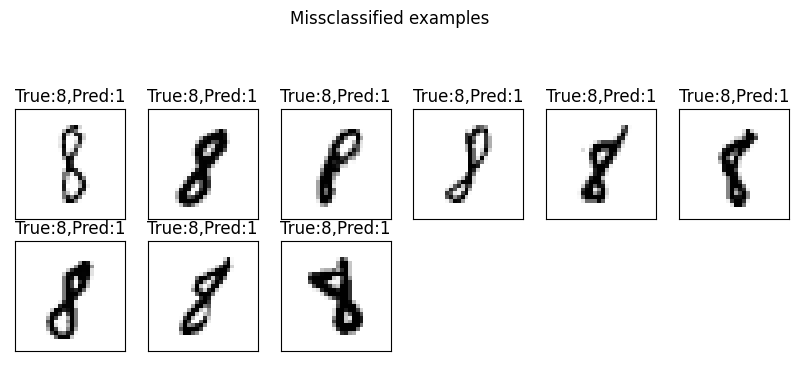

In [12]:
filters_layer_1 = model.layers[1].get_weights()[0]
filters_layer_1 = np.squeeze(filters_layer_1).reshape(32,5,5)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Missclassified examples')
w = 10
h = 10
columns = 6
rows = 6
for i in range(columns*rows +1):
    if i==nine_incorrect_examples.shape[0]:
        break
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(nine_incorrect_examples[i], cmap='Greys')
    plt.title('True:{},Pred:{}'.format(cm_index[0],cm_index[1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

> <div class="alert alert-block alert-info">
<b>Looking at the missclassifications, its understandable why the model was unable classify these examples correctly. Some of the examples are quite ambiguous, even a human labeller would probably be unable to clearly label them with good confidence. However, it does seem that there is room for improvement for some of the examples. With the use of data augmentation and hyper-parameter tuning, we should be able to further improve performance.</b>
</div>

> <div class="alert alert-block alert-info">
<b>Before we try these additional techniques, let's take a quick look at the learnt convolutional filters and feature maps, which should give us some insight on how the network is learning.</b></div>

In [13]:
model.layers

In [14]:
model.layers[1].get_weights()[0].shape

(5, 5, 1, 32)

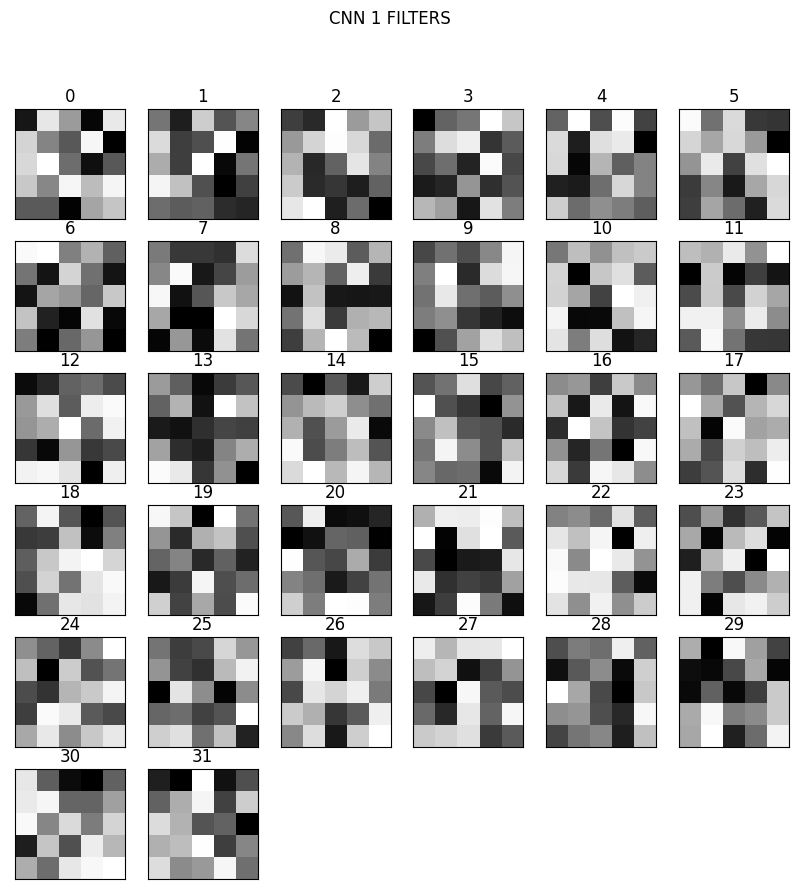

In [15]:
filters_layer_1 = model.layers[1].get_weights()[0]
filters_layer_1 = np.squeeze(filters_layer_1).reshape(32,5,5)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('CNN 1 FILTERS')
w = 10
h = 10
columns = 6
rows = 6
for i in range(columns*rows +1):
    if i==filters_layer_1.shape[0]:
        break
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(filters_layer_1[i], cmap='Greys')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
plt.show()

> <div class="alert alert-block alert-info">
<b>Shown above is the visualizatins of the 32 learnt filters in the first convolutional layer. The filters are what convolve over the images to produce the activation maps, also known as feature-maps.</b>
    <br></br>
<b>The feature-maps capture key features and patterns from the input (i.e the input image or feature maps from previous ConvBlocks).</b>
    <br></br> 
<b>The reason for visualizing feature maps is to understand what features of the input are detected and preserved in the feature maps. Lets now explore some of the feature maps to see what the model is capturing.</b>
</div>

In [16]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv2d (None, 28, 28, 32)
5 conv2d_1 (None, 14, 14, 64)


In [19]:


successive_outputs = [layer.output for layer in model.layers[1:]]
fm_model = keras.Model(inputs=model.input, outputs=successive_outputs)

successive_outputs


[<KerasTensor: shape=(None, 28, 28, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 14, 14, 32) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 14, 14, 64) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 3136) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dropout_2')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (cr

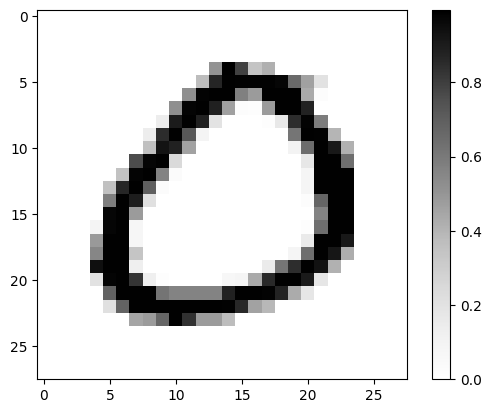

1/1 [==============================] - 0s 85ms/step


12

In [22]:
test_example = X_train[[9]]
plt.imshow(test_example[0], cmap='Greys')
plt.colorbar()
plt.show()
successive_feature_maps = fm_model.predict(test_example)
len(successive_feature_maps) # 12 for 12 layers

(1, 28, 28, 32)
input_1
(1, 14, 14, 32)
conv2d
(1, 14, 14, 32)
max_pooling2d
(1, 14, 14, 32)
batch_normalization
(1, 14, 14, 64)
dropout
(1, 7, 7, 64)
conv2d_1
(1, 7, 7, 64)
max_pooling2d_1
(1, 7, 7, 64)
batch_normalization_1
(1, 3136)
dropout_1
(1, 256)
flatten
(1, 256)
dense
(1, 10)
dropout_2


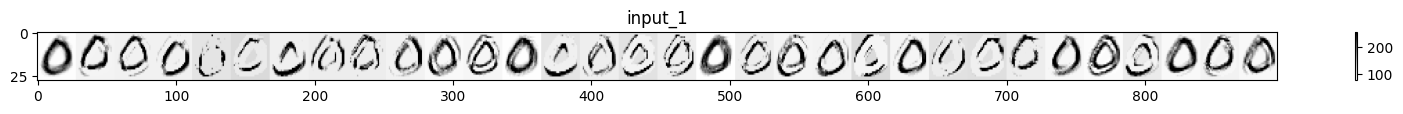

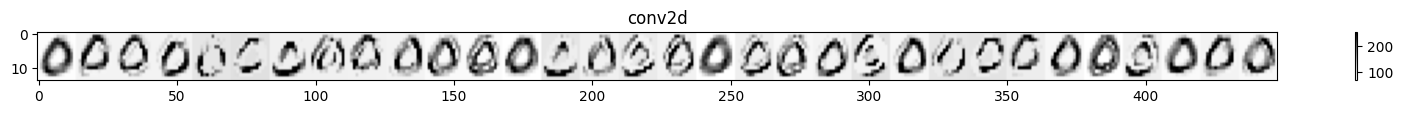

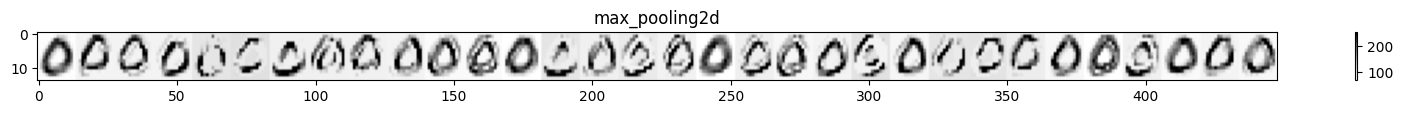

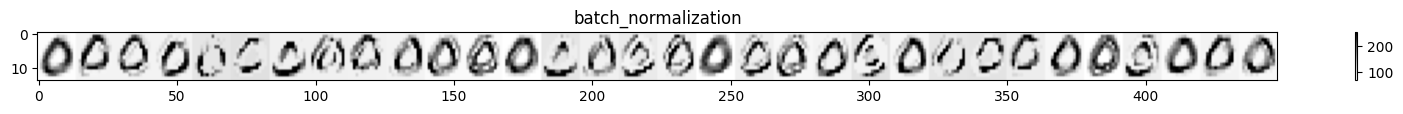

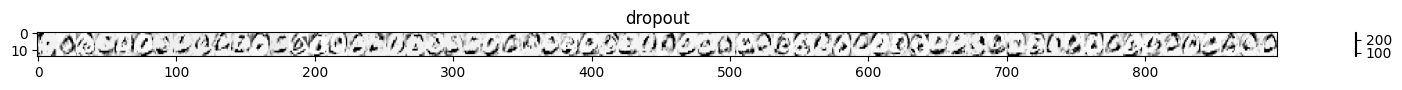

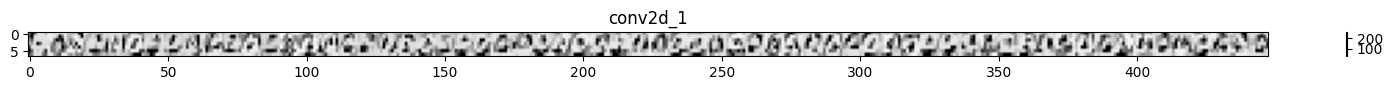

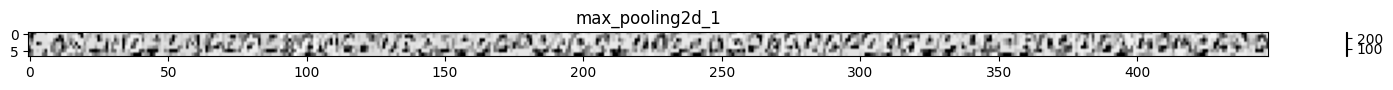

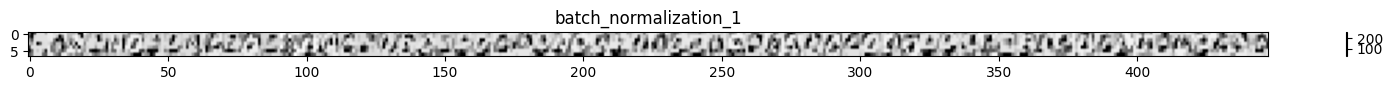

In [23]:
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    print(layer_name)
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
            
        # Display the grid
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title(layer_name) 
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='Greys' )
        plt.colorbar()
        
plt.show()